# Practical: Mapping Ecosystems with Unsupervised Machine Learning

### **Introduction**
In this practical, we will explore how to automate the mapping of land cover types (such as vegetation, water, and soil) without relying on manual human labeling. By using Unsupervised Machine Learning, we can let the computer discover natural patterns in satellite imagery based solely on spectral properties.

We will build a complete machine learning pipeline, starting from raw satellite bands and ending with a segmented map of coastal ecosystems. This approach is powerful for exploring new regions where "ground truth" data may not exist.


By the end of this notebook, you will be able to:
1.  **Engineer Features:** Create spectral indices (like NDVI) and texture measures to give the model more information.
2.  **Standardize Data:** Preprocess image data into a format suitable for machine learning algorithms.
3.  **Visualize High-Dimensional Data:** Use PCA to project complex 7-band data into a 3D "embedding space" that we can see as an RGB image.
4.  **Cluster Pixels:** Apply K-Means to group pixels with similar spectral traits into distinct land cover classes.



### Step 1. Tools for spatial data and representation analysis

We begin by importing libraries for:
- raster data (satellite images)
- numerical computation
- visualization
- unsupervised learning

This mirrors a real environmental ML workflow:
we combine GIS tools (rasterio) with ML tools (scikit-learn).


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

import rasterio
from rasterio.enums import Resampling

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans


### Step 2. Discovering the available satellite bands

Satellite images are multi-band data.
Before analysis, we must know:
- which bands are available
- how many spectral channels we have

This is always the first step when working with real EO data.


In [8]:
ROOT = Path("/workspaces/EnvDataScience-guide")
band_dir = ROOT / "data/environmental_data_week2/open-geo-tutorial-master/data/sentinel-2"


bands = sorted(band_dir.glob("*.tiff"))

print("Found bands:", len(bands))
for b in bands:
    print(" -", b.name)



Found bands: 8
 - 2018-10-13, Sentinel-2B L1C, B01.tiff
 - 2018-10-13, Sentinel-2B L1C, B02.tiff
 - 2018-10-13, Sentinel-2B L1C, B03.tiff
 - 2018-10-13, Sentinel-2B L1C, B04.tiff
 - 2018-10-13, Sentinel-2B L1C, B05.tiff
 - 2018-10-13, Sentinel-2B L1C, B06.tiff
 - 2018-10-13, Sentinel-2B L1C, B07.tiff
 - 2018-10-13, Sentinel-2B L1C, B08.tiff


- Sentinel-2 provides multiple spectral channels. 
- ML models do not see “images”. They see tensors with channels
- In Deep Learning (DL) this corresponds to checking : input_channels = 4 # or 8 or 13

Exploring metadata is important before stacking bands. We need to ensure all bands share exactly the same spatial geometry. This is critical for both environmental analysis and machine learning.

In [ ]:

for band in bands:
    with rasterio.open(band) as src:
        print(f"\n {band.name}")
        print("  Shape (H, W):", src.height, src.width)
        print("  CRS:", src.crs)
        print("  Transform:", src.transform)
        print("  Resolution (x, y):", src.res)
        print("  Bounds:", src.bounds)



 2018-10-13, Sentinel-2B L1C, B01.tiff
  Shape (H, W): 2201 2629
  CRS: EPSG:4326
  Transform: | 0.00, 0.00,-76.72|
| 0.00,-0.00, 34.73|
| 0.00, 0.00, 1.00|
  Resolution (x, y): (8.984632940281312e-05, 7.391322126306281e-05)
  Bounds: BoundingBox(left=-76.716188, bottom=34.567461, right=-76.479982, top=34.730144)

 2018-10-13, Sentinel-2B L1C, B02.tiff
  Shape (H, W): 2201 2629
  CRS: EPSG:4326
  Transform: | 0.00, 0.00,-76.72|
| 0.00,-0.00, 34.73|
| 0.00, 0.00, 1.00|
  Resolution (x, y): (8.984632940281312e-05, 7.391322126306281e-05)
  Bounds: BoundingBox(left=-76.716188, bottom=34.567461, right=-76.479982, top=34.730144)

 2018-10-13, Sentinel-2B L1C, B03.tiff
  Shape (H, W): 2201 2629
  CRS: EPSG:4326
  Transform: | 0.00, 0.00,-76.72|
| 0.00,-0.00, 34.73|
| 0.00, 0.00, 1.00|
  Resolution (x, y): (8.984632940281312e-05, 7.391322126306281e-05)
  Bounds: BoundingBox(left=-76.716188, bottom=34.567461, right=-76.479982, top=34.730144)

 2018-10-13, Sentinel-2B L1C, B04.tiff
  Shape (H, 

From the above we can conclude that each band is a 2D grid with:
- 2201 rows (height)
- 2629 columns (with)
This means every pixel location (i,j) exists in all bands.
We can safely stack bands pixe-by-pixel to form feature vectors. 

For DL is important that all channels of an image have the same height and width.
Without this alignment you cannot build a valid tensor (H,W,C)



### Step 3. Reading raster bands and controlling resolution

Satellite images can be very large.
To work efficiently on CPU, we downsample the data.

This step teaches two important ideas:
1. ML models operate on arrays, not files
2. Resolution and memory always matter in EO

"Profile"in the script below refers to the raster metadata. A raster array without a profile is just numbers. A raster array with a profile is a map. 


In [13]:
def read_band(path, out_shape=None):
    with rasterio.open(path) as src:
        if out_shape is None:
            arr = src.read(1).astype("float32")
            profile = src.profile # profile is a dictionary of metadata (coordinate system; data type ; # of bands ; dimension,etc)
                    
        else:
            arr = src.read(1,
                out_shape=out_shape,
                resampling=Resampling.bilinear
            ).astype("float32")
            profile = src.profile.copy()
            profile.update(height=out_shape[0], width=out_shape[1])
    return arr, profile

b02 = [p for p in bands if "B02" in p.name][0]  # blue
b03 = [p for p in bands if "B03" in p.name][0]  # green
b04 = [p for p in bands if "B04" in p.name][0]  # red
b08 = [p for p in bands if "B08" in p.name][0]  # nir

# Downsample for be CPU friendly.
out_shape = (512, 512)

blue, prof = read_band(b02, out_shape)
green, _ = read_band(b03, out_shape)
red, _ = read_band(b04, out_shape)
nir, _ = read_band(b08, out_shape)

print("Shape:", blue.shape)

print(prof)


Shape: (512, 512)
{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 512, 'height': 512, 'count': 1, 'crs': CRS.from_wkt('GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]'), 'transform': Affine(8.984632940281312e-05, 0.0, -76.716188,
       0.0, -7.391322126306281e-05, 34.730144), 'blockxsize': 2629, 'blockysize': 8, 'tiled': False, 'compress': 'deflate', 'interleave': 'band'}


- We are working with a 512 × 512 spatial grid
- Prof contains a similar dimension 512x512. So its compatible with the array.
- Each pixel still represents a real place on Earth
- In DL this corresponds to: resizing images; extracting manageable tiles ; choosing patch sizes

### Step 4. Technical interpretation vs model input

RGB visualization is for the environmental scientist understanding. \
Models do not “see” RGB (they see numbers.)

We visualize the image to:
- verify correctness
- relate numerical values to land cover patterns


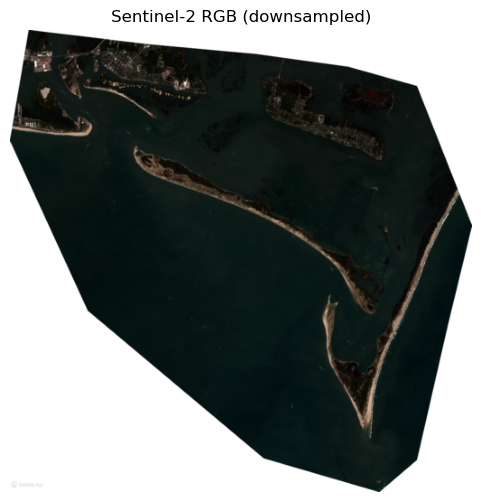

In [14]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

red_s   = scaler.fit_transform(red.reshape(-1, 1)).reshape(red.shape)
green_s = scaler.fit_transform(green.reshape(-1, 1)).reshape(green.shape)
blue_s  = scaler.fit_transform(blue.reshape(-1, 1)).reshape(blue.shape)

rgb = np.dstack([red_s, green_s, blue_s])

plt.figure(figsize=(6,6))
plt.imshow(rgb)
plt.title("Sentinel-2 RGB (downsampled)")
plt.axis("off")
plt.show()


In the image you should recognize, vegetation, water, land boundaries. 
- For DL this step is not required, but essential for environmental scientist to trust the data. 

### Step 5. Classical feature engineering (NDVI)

NDVI is a handcrafted feature designed by scientists.
It compresses spectral information into a single value related to vegetation. It is a measure of the health of vegetation. Remember, plants eat red light and reject nir (near infrared, as it harm tissues).

This represents how EO analysis was traditionally done before deep learning.


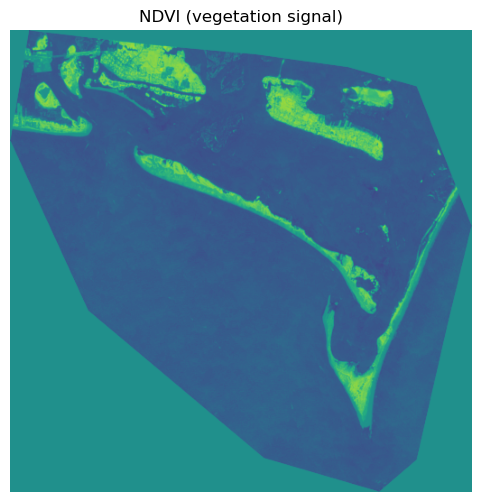

NDVI stats: -0.5932203531265259 0.7656903862953186


In [15]:
ndvi = (nir - red) / (nir + red + 1e-6) # numerator: if value is big and positive, means a healthy plant as it can absorve red and refect nir.

plt.figure(figsize=(6,6))
plt.imshow(ndvi, vmin=-1, vmax=1)
plt.title("NDVI (vegetation signal)")
plt.axis("off")
plt.show()

print("NDVI stats:", float(np.nanmin(ndvi)), float(np.nanmax(ndvi)))


NDVI map shows:

- high values → vegetation
- low/negative → water or built areas

NDVI is a manual feature. In DL, foundational models learn many NDVI-like features automatically.

### Step 6. Capturing spatial context (texture)

Single pixels are ambiguous.
Environmental meaning comes from neighborhoods.

Here we compute a simple texture measure:
how much a pixel differs from its neighbors. Two pixels can have the same NDVI, same reflectance, but very different spatial structure (forest, crops, urban blocks, water)

This approximates what convolutional filters learn automatically.

We now compute texture using convolution operations.
This reproduces the mathematical structure of a CNN layer,
but without learning any parameters.


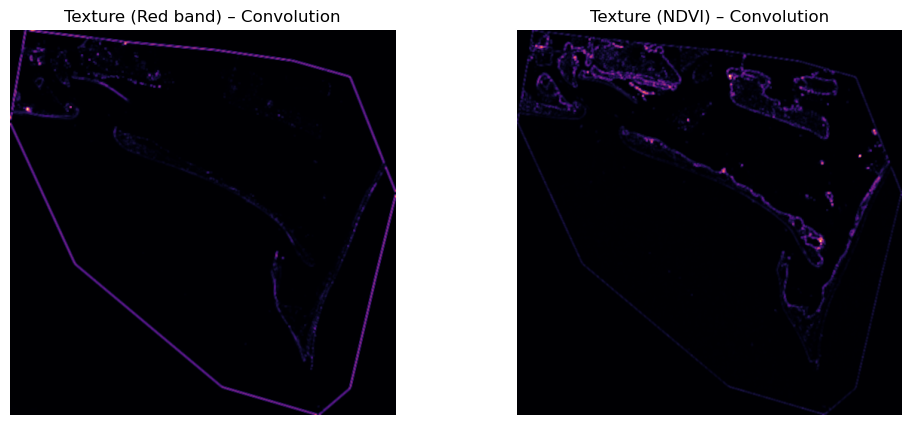

In [16]:
from scipy.ndimage import convolve

kernel = np.ones((3,3)) / 9.0

# Mean filter
mean_red = convolve(red, kernel)
mean_ndvi = convolve(ndvi, kernel)

# Local variance via convolution
texture_red_conv = convolve((red - mean_red)**2, kernel)
texture_ndvi_conv = convolve((ndvi - mean_ndvi)**2, kernel)

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.imshow(texture_red_conv, cmap="magma")
plt.title("Texture (Red band) – Convolution")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(texture_ndvi_conv, cmap="magma")
plt.title("Texture (NDVI) – Convolution")
plt.axis("off")

plt.show()


From the above image, bright areas:

- edges
- boundaries
- transitions (shorelines, vegetation borders)

This is a manual proxy for convolution.
CNNs learn hundreds of such spatial filters.

What we do here is to calculate a local variance (with a fixed spatial rule). For CNN convolution it learn spatial rules. DL does this automatically and at multiple scales.

### Step 7. Constructing a representation per pixel

We now stack all information into a single tensor.

Each pixel is represented by:
- spectral information
- vegetation signal
- spatial texture

This is NOT a learned embedding.
It is a manually constructed representation used for teaching.


In [ ]:
H, W = red.shape

X = np.stack([
    blue, green, red, nir,
    ndvi,
    texture_red_conv,
    texture_ndvi_conv
], axis=-1)  # (H, W, D)

D = X.shape[-1] # to take the dimension (7)
X2 = X.reshape(-1, D) # to calculate the number of rows

print("Embedding tensor shape:", X.shape, "=> flattened:", X2.shape)


Embedding tensor shape: (512, 512, 7) => flattened: (262144, 7)


Meaning:

- H = 512, W = 512
- D = 7 features per pixel

Flattened:
262,144 pixels × 7 features
Every single pixel now has a "profile" of 7 numbers describing it.

In foundation models:
- pixels/patches → D = 256–1024 learned features
- same idea, richer representation

### Step 8. Understanding representation space with PCA

Representations live in high-dimensional space. We cannot visualize them directly.

PCA projects the representation down to 3 dimensions for visualization.
This does NOT train a model (it helps us understand the structure).

For this practical we call it an embedding because we are embedding (placing) every pixel into a specific location in a 3D space.


Explained variance: [0.635 0.199 0.111]


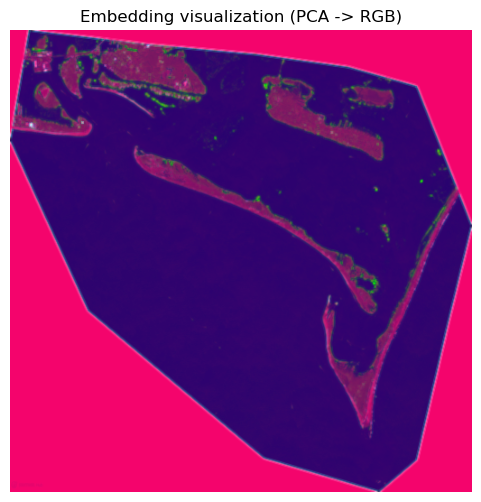

In [ ]:
# Standardize features 
scaler = StandardScaler()
X2s = scaler.fit_transform(X2)

# PCA to 3 dimensions to visualize (like projecting embeddings)
pca = PCA(n_components=3, random_state=42)
E3 = pca.fit_transform(X2s)  # (N, 3)

print("Explained variance:", pca.explained_variance_ratio_.round(3))

# Turn PCA components into an image
Eimg = E3.reshape(H, W, 3)

from matplotlib.colors import Normalize
Edisp = np.dstack([
    Normalize(vmin=np.nanmin(Eimg[..., i]), vmax=np.nanmax(Eimg[..., i]))(Eimg[..., i])
    for i in range(3)
])
plt.figure(figsize=(6,6))
plt.imshow(Edisp)
plt.title("Embedding visualization (PCA -> RGB)")
plt.axis("off")
plt.show()


The PCA RGB image shows:

- regions with similar representations
- spatial coherence without labels

Explained variance (63% + 18% + 11%) means that most information is captured in just a few directions

### Step 9. Discovering land patterns without labels

We now cluster pixels using their representations.
No land-cover map is used.

This demonstrates how foundation model embeddings can be used
without supervision.


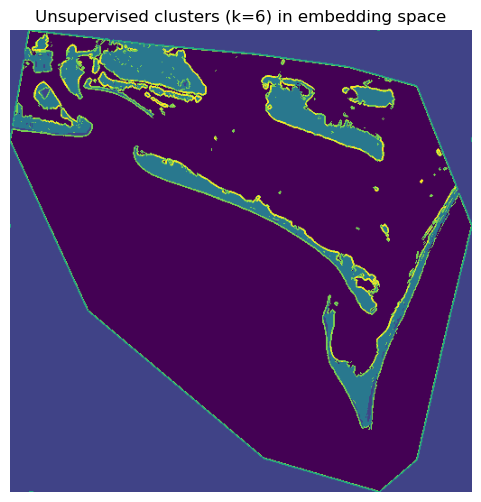

In [ ]:
# Sample pixels for faster clustering fit
rng = np.random.default_rng(42)
N = X2s.shape[0]
idx = rng.choice(N, size=min(40000, N), replace=False) # kmeans is a heavy process, so if for eg., 40k pixels are chosen randomly, they will statistically represent the whole image well enough.

k = 6  
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
kmeans.fit(X2s[idx])

labels = kmeans.predict(X2s).reshape(H, W)

plt.figure(figsize=(6,6))
plt.imshow(labels)
plt.title(f"Unsupervised clusters (k={k}) in embedding space")
plt.axis("off")
plt.show()


Clusters correspond to:

- vegetation
- water
- sand
- built areas

In DL this is exactly how embeddings are user for:

- unsupervised mapping
- pseudo-labeling
- data exploration

### Step 10. Interpreting clusters using environmental knowledge

Clusters alone are abstract.
We interpret them using NDVI (a known environmental signal).
This is how scientists connect ML outputs to real meaning.


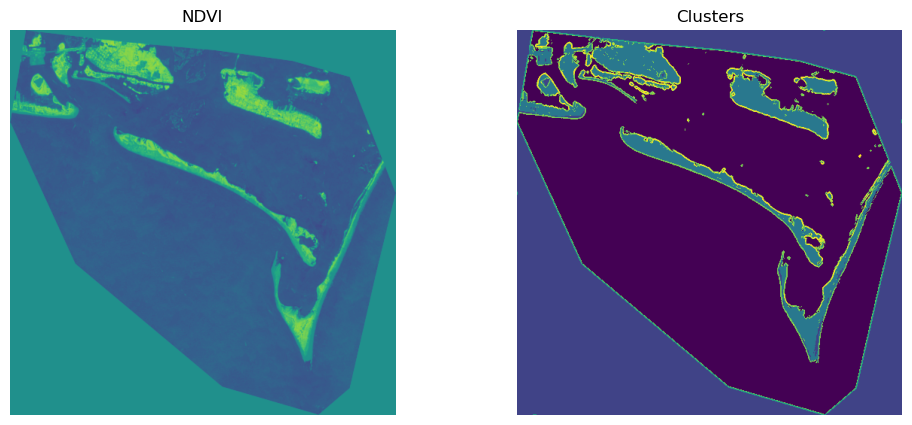

Cluster mean NDVI (higher = greener):
  cluster 2: mean NDVI = 0.372
  cluster 5: mean NDVI = 0.026
  cluster 1: mean NDVI = 0.000
  cluster 3: mean NDVI = -0.053
  cluster 4: mean NDVI = -0.103
  cluster 0: mean NDVI = -0.413


In [16]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.imshow(ndvi, vmin=-1, vmax=1)
plt.title("NDVI")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(labels)
plt.title("Clusters")
plt.axis("off")

plt.show()

# Summarize clusters by mean NDVI
means = []
for c in range(k):
    means.append((c, float(ndvi[labels==c].mean())))
means_sorted = sorted(means, key=lambda x: x[1], reverse=True)
print("Cluster mean NDVI (higher = greener):")
for c, m in means_sorted:
    print(f"  cluster {c}: mean NDVI = {m:.3f}")


Clusters with higher mean NDVI → vegetation \
Lower → water / built areas

In DL this is representation → interpretation → decision.